# Chapter 10: Outliers and Special Events

## Correcting outliers that cause seasonality swings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

from prophet.plot import add_changepoints_to_plot

df = pd.read_csv('../data/instagram_natgeo.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.columns = ['ds', 'y']

c:\users\gregr\appdata\local\programs\python\python38\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


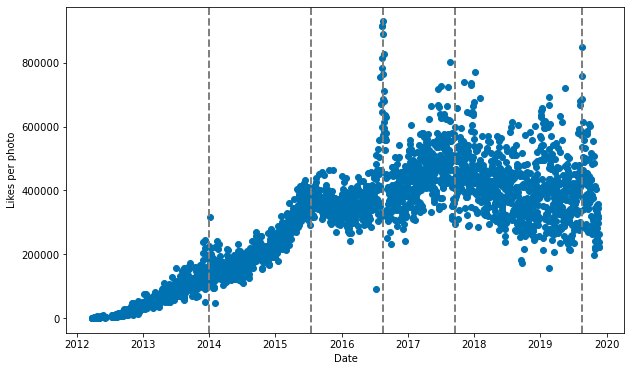

In [2]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.axvline(pd.to_datetime('2014-01-01'), c='gray', ls='--', lw=2)
plt.axvline(pd.to_datetime('2015-07-15'), c='gray', ls='--', lw=2)
plt.axvline(pd.to_datetime('2016-08-15'), c='gray', ls='--', lw=2)
plt.axvline(pd.to_datetime('2017-09-15'), c='gray', ls='--', lw=2)
plt.axvline(pd.to_datetime('2019-08-20'), c='gray', ls='--', lw=2)
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()

13:53:27 - cmdstanpy - INFO - Chain [1] start processing
13:53:27 - cmdstanpy - INFO - Chain [1] done processing


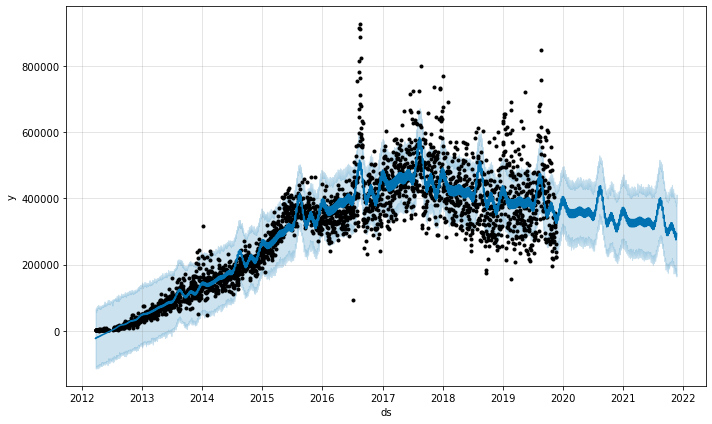

In [3]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

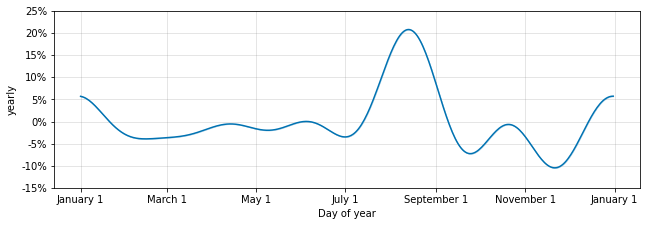

In [4]:
from prophet.plot import plot_yearly

plot_yearly(model, figsize=(10.5, 3.25))
plt.show()

In [5]:
df2 = df[(df['ds'] < '2016-07-29') | (df['ds'] > '2016-09-01')]

13:53:30 - cmdstanpy - INFO - Chain [1] start processing
13:53:30 - cmdstanpy - INFO - Chain [1] done processing


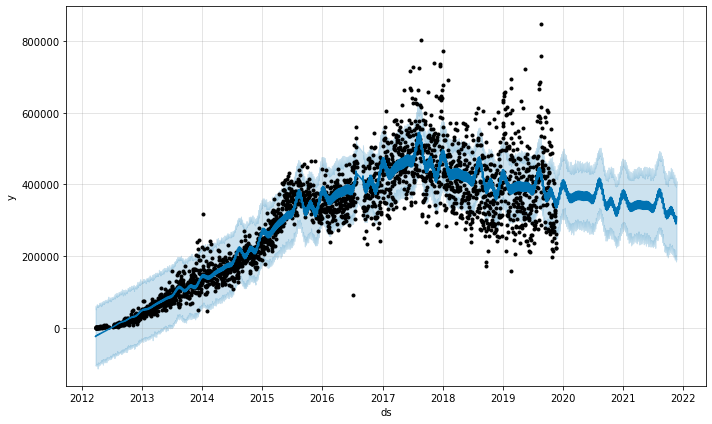

In [6]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6)
model.fit(df2)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

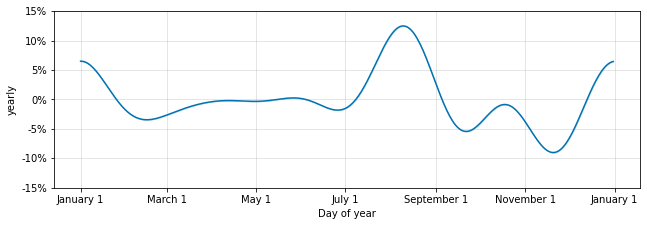

In [7]:
plot_yearly(model, figsize=(10.5, 3.25))
plt.show()

## Correcting outliers that cause wide uncertainty intervals

In [8]:
df3 = df.copy()
df3.loc[df3['ds'].dt.year == 2016, 'y'] = 100000

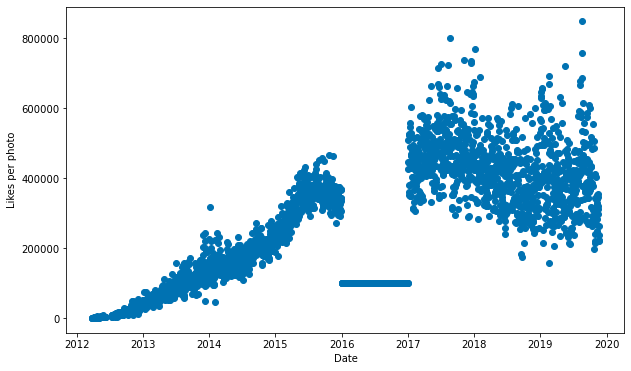

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df3['ds'], y=df3['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()

13:53:35 - cmdstanpy - INFO - Chain [1] start processing
13:53:36 - cmdstanpy - INFO - Chain [1] done processing


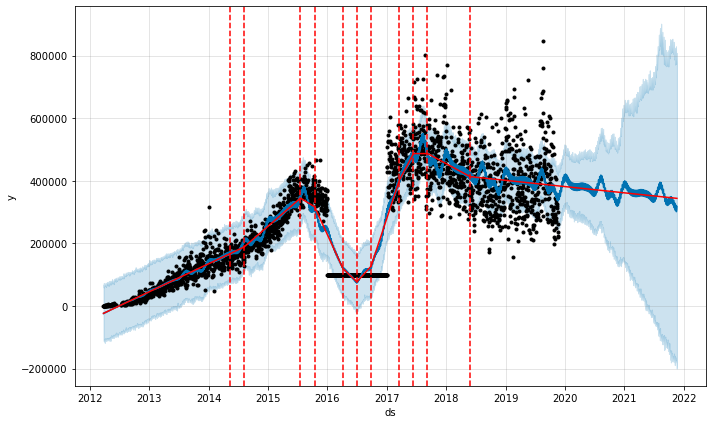

In [10]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6)
model.fit(df3)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

In [11]:
df3.loc[df3['ds'].dt.year == 2016, 'y'] = None

13:53:39 - cmdstanpy - INFO - Chain [1] start processing
13:53:39 - cmdstanpy - INFO - Chain [1] done processing


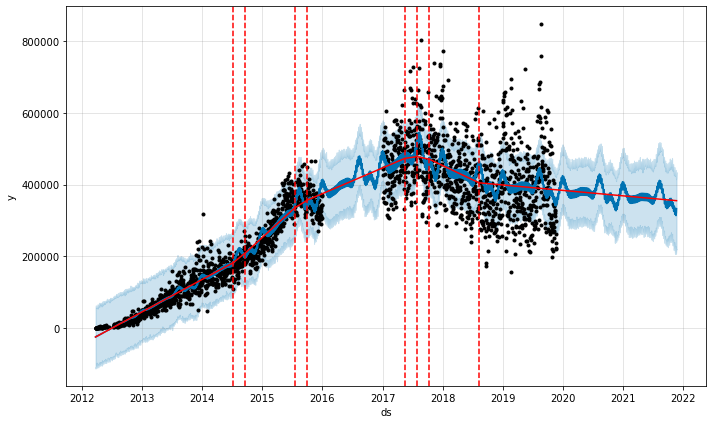

In [12]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6)
model.fit(df3)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

## Detecting outliers automatically

### Winsorizing

In [13]:
from scipy import stats

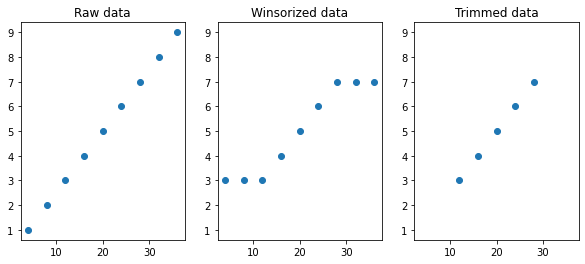

In [14]:
from matplotlib.ticker import MaxNLocator

x = [4 * val for val in [1, 2, 3, 4, 5, 6, 7, 8, 9]]
y = [.25 * val for val in x]

fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(x, y)
ax1.title.set_text('Raw data')

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(x, stats.mstats.winsorize(y, .25))
ax2.title.set_text('Winsorized data')
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(x[2:-2], y[2:-2])
ax3.title.set_text('Trimmed data')
ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
ax3.set_xlim(ax1.get_xlim())
ax3.set_ylim(ax1.get_ylim())

plt.show()

In [15]:
df4 = df.copy().dropna()
df4['y'] = stats.mstats.winsorize(df4['y'], limits=(0, .05), axis=0)

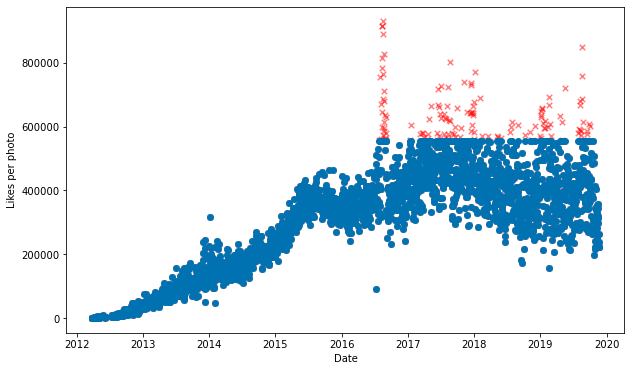

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='r', alpha=.5, marker='x', s=30)
plt.scatter(x=df4['ds'], y=df4['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()

### Standard deviation

In [17]:
df5 = df.copy().dropna()
df5 = df5[(stats.zscore(df5['y']) < 1.65)]

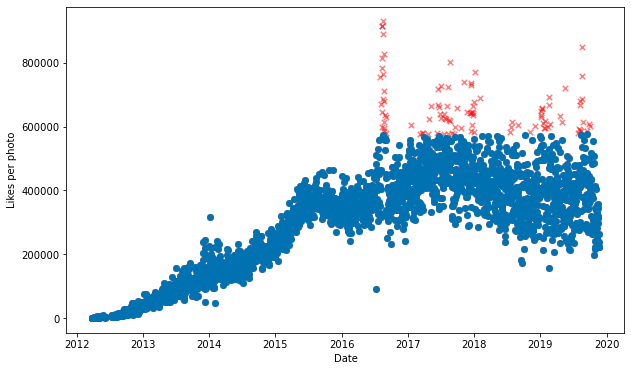

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='r', alpha=.5, marker='x', s=30)
plt.scatter(x=df5['ds'], y=df5['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()

### Moving average

In [19]:
df6 = df.copy().dropna()

df6['moving_average'] = df6.rolling(window=300,
                                    min_periods=1,
                                    center=True,
                                    on='ds')['y'].mean()
df6['std_dev'] = df6.rolling(window=300,
                             min_periods=1,
                             center=True,
                             on='ds')['y'].std()
df6['lower'] = df6['moving_average'] - 1.65 * df6['std_dev']
df6['upper'] = df6['moving_average'] + 1.65 * df6['std_dev']

df6 = df6[(df6['y'] < df6['upper']) & (df6['y'] > df6['lower'])]

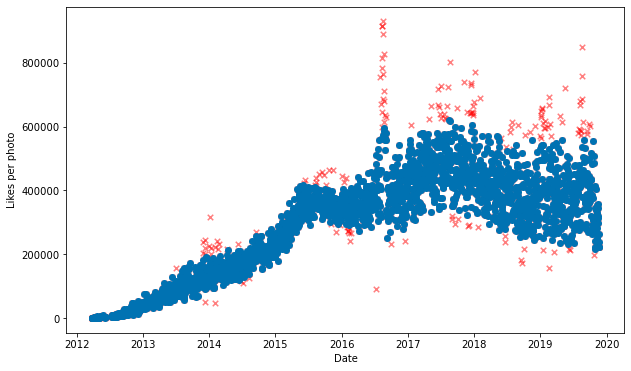

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='r', alpha=.5, marker='x', s=30)
plt.scatter(x=df6['ds'], y=df6['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()

### Error standard deviation

In [21]:
df7 = df.copy().dropna().reset_index()

In [22]:
model = Prophet(seasonality_mode='multiplicative',
                yearly_seasonality=6,
                seasonality_prior_scale=.01,
                changepoint_prior_scale=.01,
                interval_width=.90)
model.fit(df7)
forecast = model.predict()

13:53:43 - cmdstanpy - INFO - Chain [1] start processing
13:53:44 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
df8 = df7[(df7['y'] > forecast['yhat_lower']) &
         (df7['y'] < forecast['yhat_upper'])]

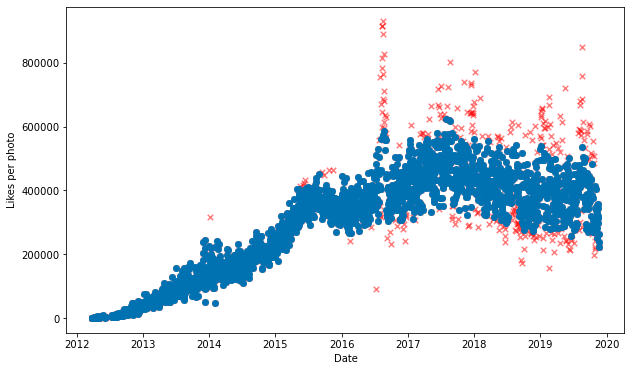

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['ds'], y=df['y'], c='r', alpha=.5, marker='x', s=30)
plt.scatter(x=df8['ds'], y=df8['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Date')
plt.ylabel('Likes per photo')
plt.show()

## Modeling outliers as special events

In [25]:
promo = pd.DataFrame({'holiday': 'Promo event',
                      'ds' : pd.to_datetime(['2016-07-29']),
                      'lower_window': 0,
                      'upper_window': 34})
future_promo = pd.DataFrame({'holiday': 'Promo event',
                      'ds' : pd.to_datetime(['2020-06-01']),
                      'lower_window': 0,
                      'upper_window': 34})

promos = pd.concat([promo, future_promo])

13:53:46 - cmdstanpy - INFO - Chain [1] start processing
13:53:48 - cmdstanpy - INFO - Chain [1] done processing


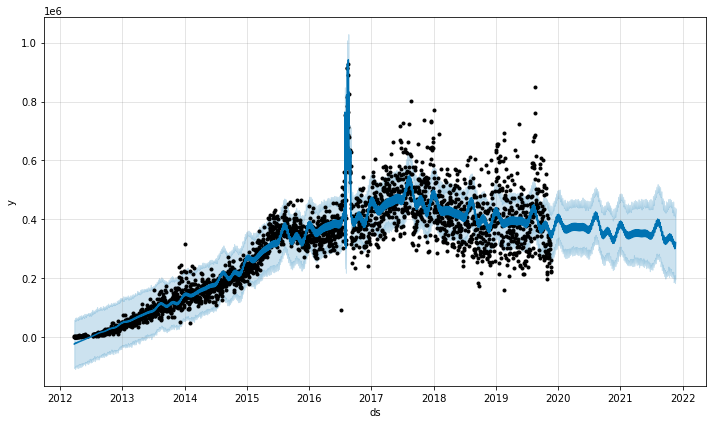

In [26]:
model = Prophet(seasonality_mode='multiplicative',
                holidays=promo,
                yearly_seasonality=6)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

13:53:51 - cmdstanpy - INFO - Chain [1] start processing
13:53:52 - cmdstanpy - INFO - Chain [1] done processing


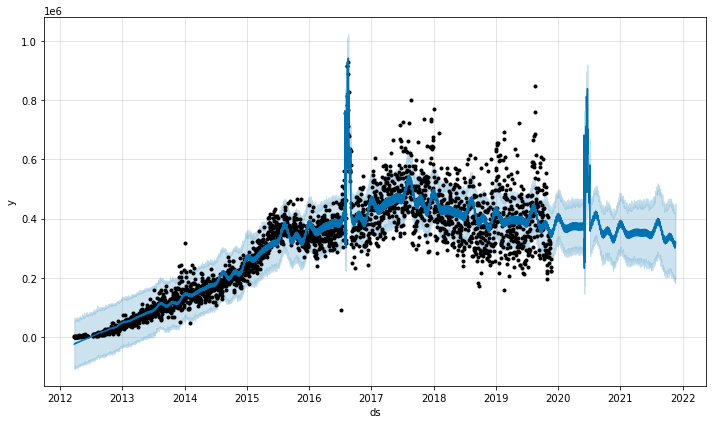

In [27]:
model = Prophet(seasonality_mode='multiplicative',
                holidays=promos,
                yearly_seasonality=6)
model.fit(df)
future = model.make_future_dataframe(periods=365 * 2)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

### Modeling shocks as special events

In [28]:
df = pd.read_csv('../data/pedestrian_counts.csv')
df['Date'] = pd.to_datetime(df['Date'])

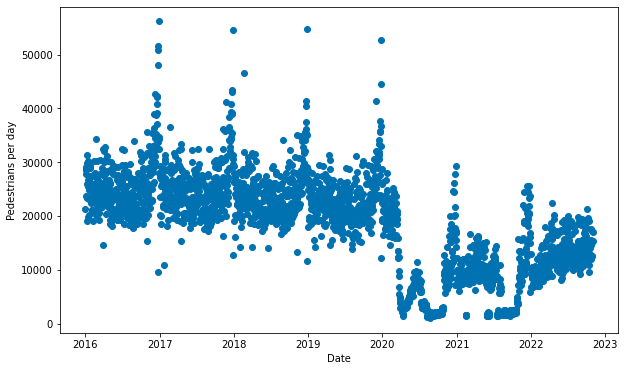

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df['Date'],
            y=df['Daily_Counts'],
            c='#0072B2')
plt.xlabel('Date')
plt.ylabel('Pedestrians per day')
plt.show()

In [30]:
df = df[['Date', 'Daily_Counts']]
df.columns = ['ds', 'y']

13:53:55 - cmdstanpy - INFO - Chain [1] start processing
13:53:56 - cmdstanpy - INFO - Chain [1] done processing


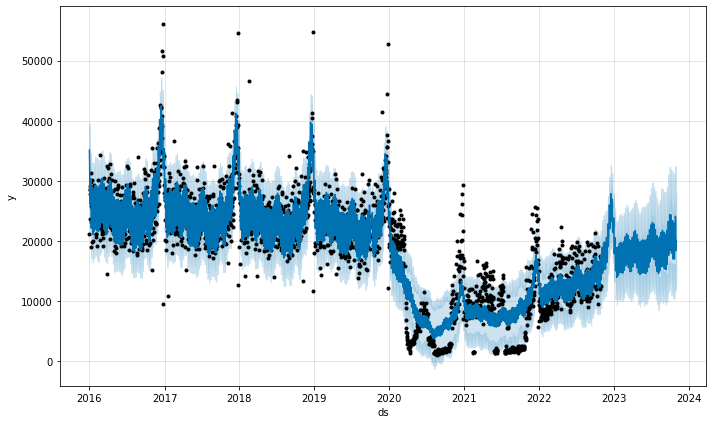

In [31]:
model = Prophet(seasonality_mode='multiplicative')
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

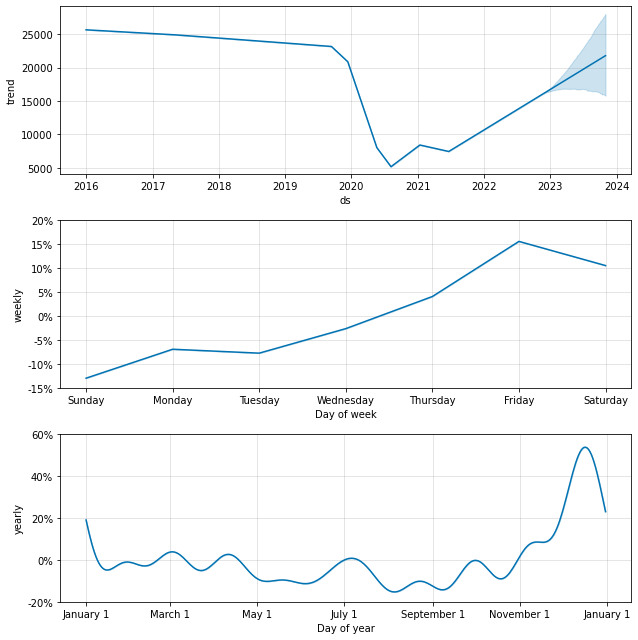

In [32]:
fig2 = model.plot_components(forecast)
plt.show()

In [33]:
lockdowns = pd.DataFrame([
    {'holiday':'lockdown1',
     'ds': pd.to_datetime('2020-03-21'),
     'lower_window': 0,
     'upper_window': 77},
    {'holiday':'lockdown2',
     'ds': pd.to_datetime('2020-07-09'),
     'lower_window': 0,
     'upper_window': 110},
    {'holiday':'lockdown3',
     'ds': pd.to_datetime('2021-02-13'),
     'lower_window': 0,
     'upper_window': 4},
    {'holiday':'lockdown4',
     'ds': pd.to_datetime('2021-05-28'),
     'lower_window': 0,
     'upper_window': 13}])

13:54:01 - cmdstanpy - INFO - Chain [1] start processing
13:54:10 - cmdstanpy - INFO - Chain [1] done processing


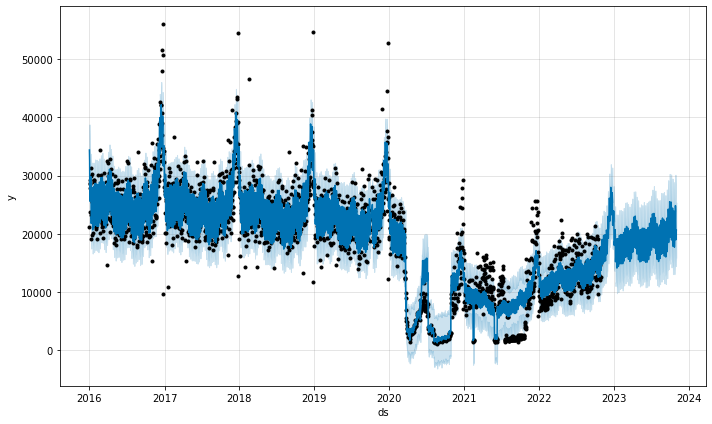

In [34]:
model = Prophet(seasonality_mode='multiplicative',
                holidays=lockdowns)
model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

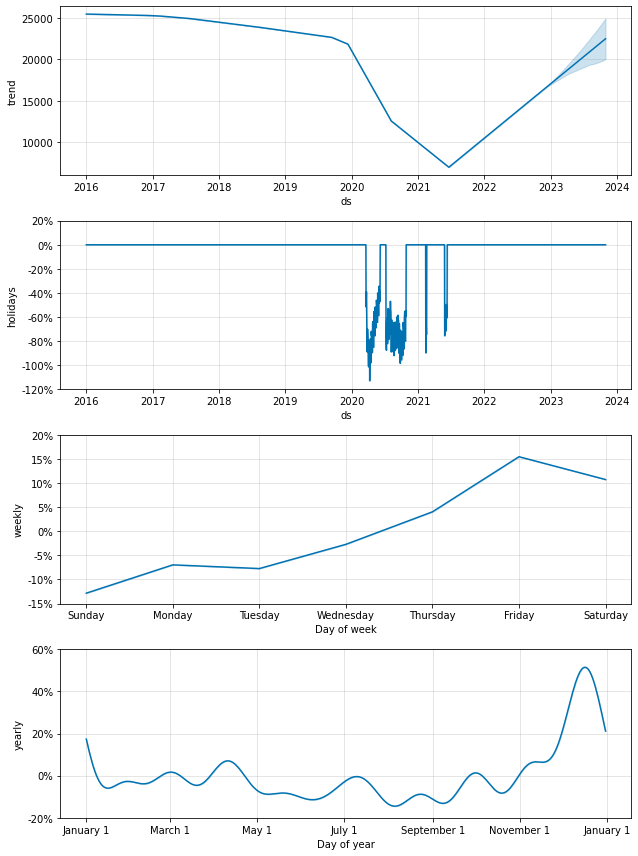

In [35]:
fig2 = model.plot_components(forecast)
plt.show()

In [36]:
df['pre_covid'] = df['ds'] < '2020-03-21'
df['post_covid'] = df['ds'] > '2021-06-10'

13:54:15 - cmdstanpy - INFO - Chain [1] start processing
13:54:22 - cmdstanpy - INFO - Chain [1] done processing


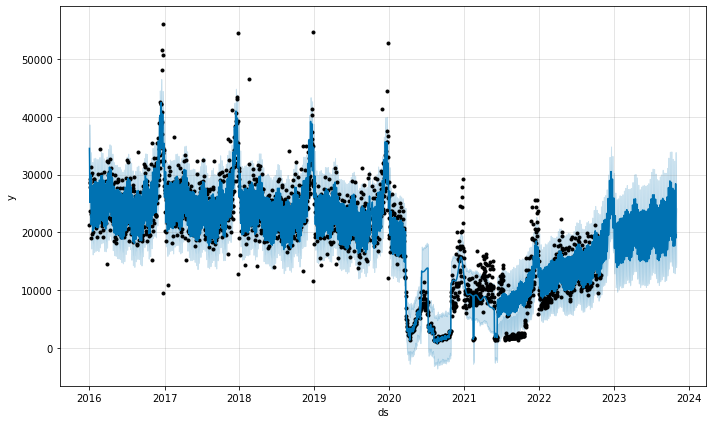

In [37]:
model = Prophet(seasonality_mode='multiplicative',
                weekly_seasonality=False,
                holidays=lockdowns)
model.add_seasonality(
    name='weekly_pre_covid',
    period=7,
    fourier_order=3,
    condition_name='pre_covid',
)
model.add_seasonality(
    name='weekly_post_covid',
    period=7,
    fourier_order=3,
    condition_name='post_covid',
)
model.fit(df)
future = model.make_future_dataframe(periods=365)
future['pre_covid'] = future['ds'] < '2020-03-21'
future['post_covid'] = future['ds'] > '2021-06-10'
forecast = model.predict(future)
fig = model.plot(forecast)
plt.show()

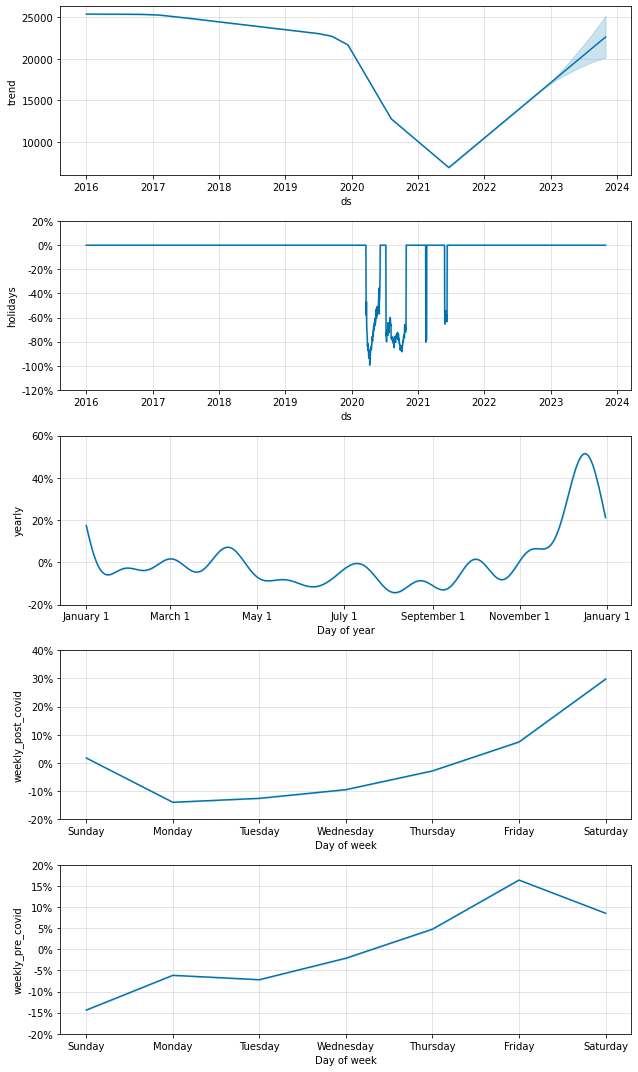

In [38]:
fig2 = model.plot_components(forecast)
plt.show()